In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import os
import tables
from scipy import linalg
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
from scipy.stats import gaussian_kde

# Helper Functions

In [3]:
def even_spaced(sample, n=50, fudge=0.05):
    dist = np.max(sample) - np.min(sample)
    minimum = np.min(sample) - dist*fudge
    maximum = np.max(sample) + dist*fudge
    return np.linspace(minimum, maximum, n)

In [4]:
def component_plot(samp, axes, cmap, bw=None, thin=1):
    n = samp.shape[1]
    # first plot the diagonal
    for i in xrange(n):
        ax = axes[i,i]
        sample = samp[::thin,i]
        x = even_spaced(sample)
        kde = gaussian_kde(sample.T, bw)
        handle, = ax.plot(x, kde(x), c=matplotlib.cm.get_cmap(cmap)(0.5))
        
    # plot below diagonal
    for i in xrange(n):
        for j in xrange(i+1, n):
            ax = axes[j,i]
            sample = samp[::thin, [i,j]]
            kde = gaussian_kde(sample.T, bw)
            
            x0 = even_spaced(sample[:,0])
            x1 = even_spaced(sample[:,1])
            
            x, y = np.meshgrid(x0, x1)
            z = kde(np.column_stack([x.ravel(), y.ravel()]).T).reshape(x.shape)
            ax.contour(x, y, z, cmap=cmap)
    
    # blank above diagonal
    for i in xrange(n):
        for j in xrange(i+1, n):
            ax = axes[i, j]
            ax.set_axis_off()
    return handle     

In [5]:
def component_plot_truth(truth, axes, color='black'):
    n = truth.shape[0]
    for i in xrange(n):
        ax = axes[i,i]
        ax.axvline(truth[i], linestyle='--', color=color)
        
    for i in xrange(n):
        for j in xrange(i+1, n):
            ax = axes[j,i]
            ax.scatter(truth[i], truth[j], marker='x', color=color, zorder=1000)
    return mlines.Line2D([], [], color=color, marker='x', linestyle='--')

In [6]:
def component_plot_axes_off(axes):
    for i in xrange(1, len(axes)):
        for j in xrange(0, len(axes)):
            ax = axes[j,i]
            ax.yaxis.set_major_locator(plt.NullLocator())

    for i in xrange(0, len(axes)):
        for j in xrange(0, len(axes)-1):
            ax = axes[j,i]
            ax.xaxis.set_major_locator(plt.NullLocator())

# Summary

In [7]:
def shifted_color_map(cmap, start=0, midpoint=0.5, stop=1.0, name='shiftedcmap'):
    '''
    Function to offset the "center" of a colormap. Useful for
    data with a negative min and positive max and you want the
    middle of the colormap's dynamic range to be at zero

    Input
    -----
      cmap : The matplotlib colormap to be altered
      start : Offset from lowest point in the colormap's range.
          Defaults to 0.0 (no lower ofset). Should be between
          0.0 and `midpoint`.
      midpoint : The new center of the colormap. Defaults to 
          0.5 (no shift). Should be between 0.0 and 1.0. In
          general, this should be  1 - vmax/(vmax + abs(vmin))
          For example if your data range from -15.0 to +5.0 and
          you want the center of the colormap at 0.0, `midpoint`
          should be set to  1 - 5/(5 + 15)) or 0.75
      stop : Offset from highets point in the colormap's range.
          Defaults to 1.0 (no upper ofset). Should be between
          `midpoint` and 1.0.
    '''
    cdict = {
        'red': [],
        'green': [],
        'blue': [],
        'alpha': []
    }

    # regular index to compute the colors
    reg_index = np.linspace(start, stop, 257)

    # shifted index to match the data
    shift_index = np.hstack([
        np.linspace(0.0, midpoint, 128, endpoint=False), 
        np.linspace(midpoint, 1.0, 129, endpoint=True)
    ])

    for ri, si in zip(reg_index, shift_index):
        r, g, b, a = cmap(ri)

        cdict['red'].append((si, r, r))
        cdict['green'].append((si, g, g))
        cdict['blue'].append((si, b, b))
        cdict['alpha'].append((si, a, a))

    newcmap = matplotlib.colors.LinearSegmentedColormap(name, cdict)
    plt.register_cmap(cmap=newcmap)

    return newcmap

## Variance Comparison - Bayesian vs. Collocation

In [8]:
root_dir = 'eit_results/regular_n=96/'
compare_dir = 'eit_results/regular_n=96_collocate/'

In [9]:
field_pts = np.load(os.path.join(root_dir, 'field_pts.npy'))

In [10]:
burn = 5000
samp_base = np.load(os.path.join(root_dir, 'results.npy'))
samp_compare = np.load(os.path.join(compare_dir, 'results.npy'))
var_base = np.std(samp_base[burn:], axis=0)
var_compare = np.std(samp_compare[burn:], axis=0)

In [11]:
min_val = (var_base/var_compare).min()
max_val = (var_base/var_compare).max()

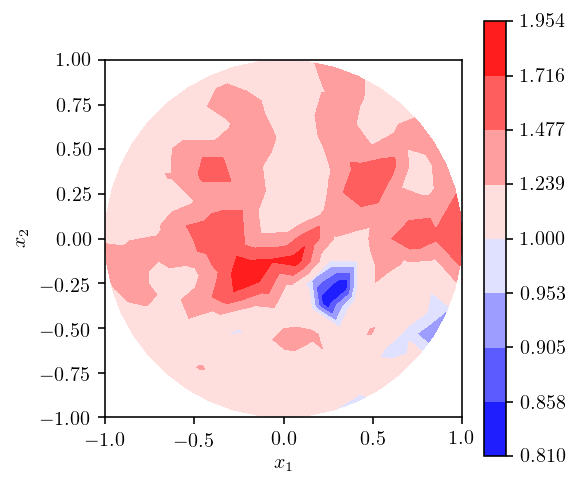

In [12]:
plt.figure(figsize=(4, 4))
levels = np.concatenate([np.linspace(min_val, 1.0, 5), np.linspace(1.0, max_val, 5)[1:]])
new_cm = shifted_color_map(plt.cm.bwr, midpoint=(1.-min_val) / (max_val-min_val))
plt.tricontourf(field_pts[:,0], field_pts[:,1], var_base/var_compare, levels, cmap=new_cm)
plt.gca().set_aspect('equal')
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.colorbar()

plt.savefig('figures/eit_variance_comparison.pdf', bbox_inches='tight', transparent=True)

Nice to have something more _quantitative_ here.

## Variance Comparison - Different $N$

In [13]:
ns = [52, 96, 127, 165, 209]
ref_n = 259
#ns = [165, 209]

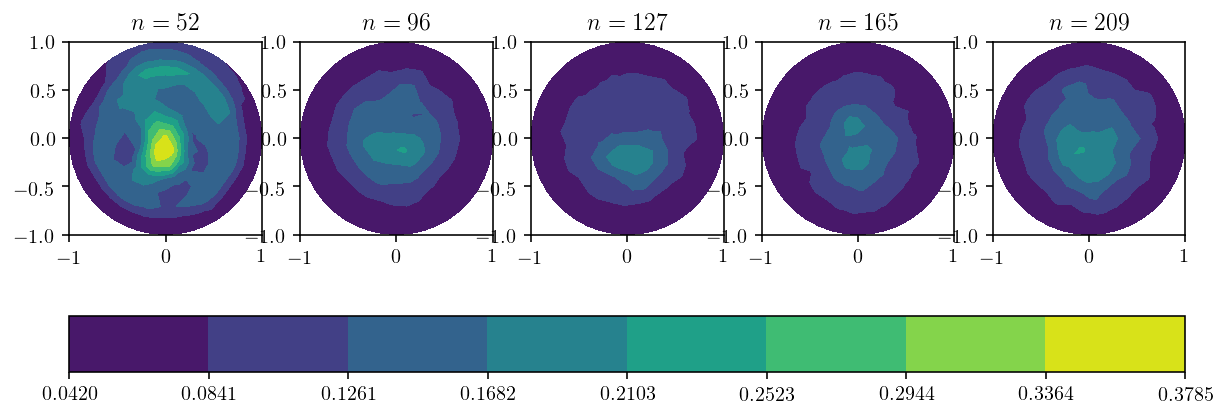

In [14]:
samples = [np.load(os.path.join('eit_results/regular_n={}'.format(n), 'results.npy')) for n in ns]
variances = [np.std(s[burn:, :], axis=0 ) for s in samples]
max_variance = np.max([np.max(v) for v in variances])
min_variance = np.min([np.min(v) for v in variances])
levels = np.linspace(min_variance, max_variance, 9)
i = 1 
fig, axes = plt.subplots(nrows=1, ncols=len(ns), figsize=(10, 5))
for a, n, s in zip(axes, ns, variances):
    im = a.tricontourf(field_pts[:,0], field_pts[:, 1], s, levels)
    a.set_aspect('equal')
    a.set_title('$n={}$'.format(n))

plt.gcf().colorbar(im, ax=axes.ravel().tolist(), orientation='horizontal')

In [15]:
stat_results = []
for n in ns:
    base_samples = np.exp(np.load(os.path.join('eit_results/regular_n={}_collocate'.format(n), 'results.npy'))[burn:, :])
    compare_samples = np.exp(np.load(os.path.join('eit_results/regular_n={}'.format(n), 'results.npy'))[burn:, :])
    
    base_mu = np.mean(base_samples, axis=0)
    base_cov = np.cov(base_samples.T)
    print np.mean(np.linalg.norm(compare_samples - base_mu[None, :])), np.mean(np.diag(base_cov)),
    sqrt_base_cov = np.real_if_close(linalg.sqrtm(base_cov))
    
    solved = np.linalg.solve(sqrt_base_cov, (compare_samples - base_mu[None,:]).T)
    res = np.mean(np.linalg.norm(solved, 2, axis=0)**2) / solved.shape[0]
    print res
    stat_results.append(res)

977.367941276 0.0258145240413 70583.9852374
450.345358112 0.0101466535471 34.1752067811
394.638217059 0.0125939032765 16.532188748
453.993427694 0.0142178187291 19.30583504
478.54072766 0.0203191952841 11.339924948


In [16]:
stat_results

[70583.985237419547,
 34.175206781141135,
 16.532188748027863,
 19.305835040025649,
 11.339924948045315]

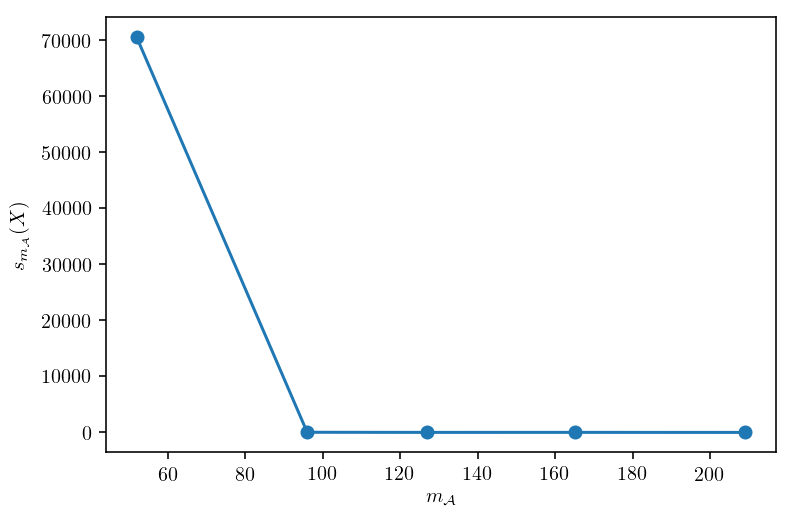

In [17]:
plt.plot(ns, stat_results, marker='o')
plt.xlabel('$m_\\mathcal{A}$')
plt.ylabel('$s_{m_\\mathcal{A}}(X)$')
plt.savefig('figures/eit_statistic_convergence.pdf', bbox_inches='tight', transparent=True)

In [57]:
n_pcs = 5
ns = [52, 96, 127, 165, 209]
n_pts_coarse = 96
n_pts_fine = 259
ref_n = 165

In [58]:
base_samples = np.exp(np.load(os.path.join('eit_results/regular_n={}_collocate'.format(ref_n), 'results.npy'))[burn:, :])
ref_cov = np.cov(base_samples[burn:].T)
pmm_name_coarse = 'eit_results/regular_n={}/'.format(n_pts_coarse)
pmm_samples_coarse = np.load(os.path.join(pmm_name_coarse, 'results.npy'))[burn:, :]
coll_name_coarse = 'eit_results/regular_n={}_collocate/'.format(n_pts_coarse)
coll_samples_coarse = np.load(os.path.join(coll_name_coarse, 'results.npy'))[burn:, :]
pmm_name_fine = 'eit_results/regular_n={}/'.format(n_pts_fine)
pmm_samples_fine = np.load(os.path.join(pmm_name_fine, 'results.npy'))[burn:, :]
coll_name_fine = 'eit_results/regular_n={}_collocate/'.format(n_pts_fine)
coll_samples_fine = np.load(os.path.join(coll_name_fine, 'results.npy'))[burn:, :]

In [59]:
evals, evecs = np.linalg.eig(ref_cov)
evecs = evecs[:, 0:n_pcs]

In [60]:
pmm_projection_coarse = np.dot(pmm_samples_coarse, evecs)
coll_projection_coarse = np.dot(coll_samples_coarse, evecs)
pmm_projection_fine = np.dot(pmm_samples_fine, evecs)
coll_projection_fine = np.dot(coll_samples_fine, evecs)
truth_projection = np.dot(base_samples, evecs)

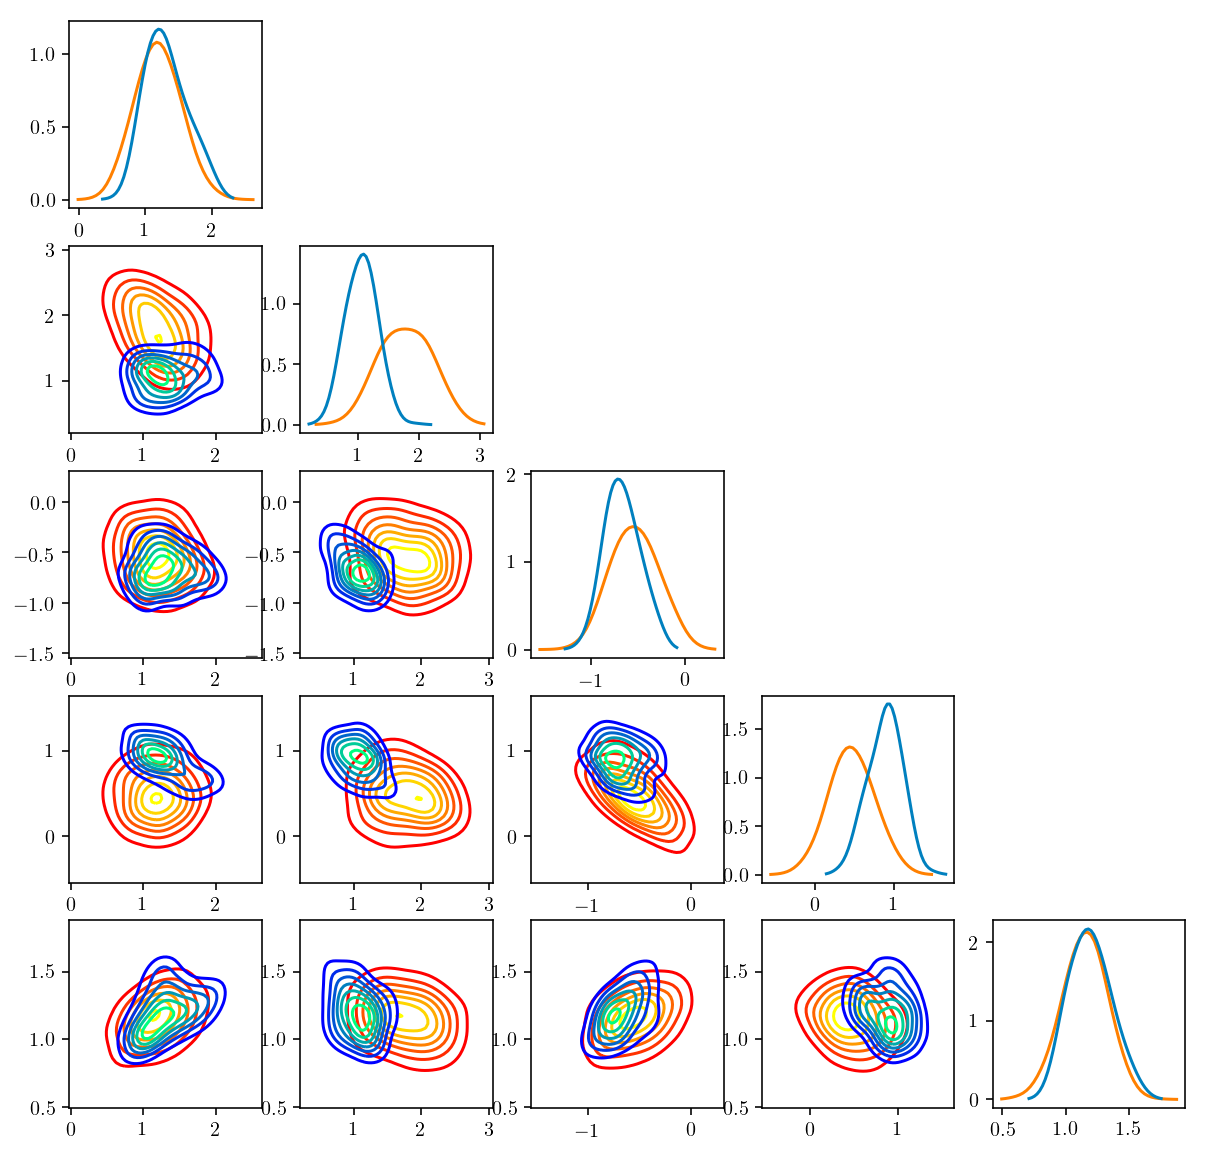

In [63]:
bw = 0.4
thin = 10
fig, axes = plt.subplots(evecs.shape[1], evecs.shape[1], False, False, figsize=(10,10))
h_pmm = component_plot(pmm_projection_coarse, axes, cmap='autumn', bw=bw, thin=thin)
h_coll = component_plot(coll_projection_coarse, axes, cmap='winter', bw=bw, thin=thin)
#h_coll = component_plot(truth_projection, axes, cmap='Greys', bw=bw, thin=thin)

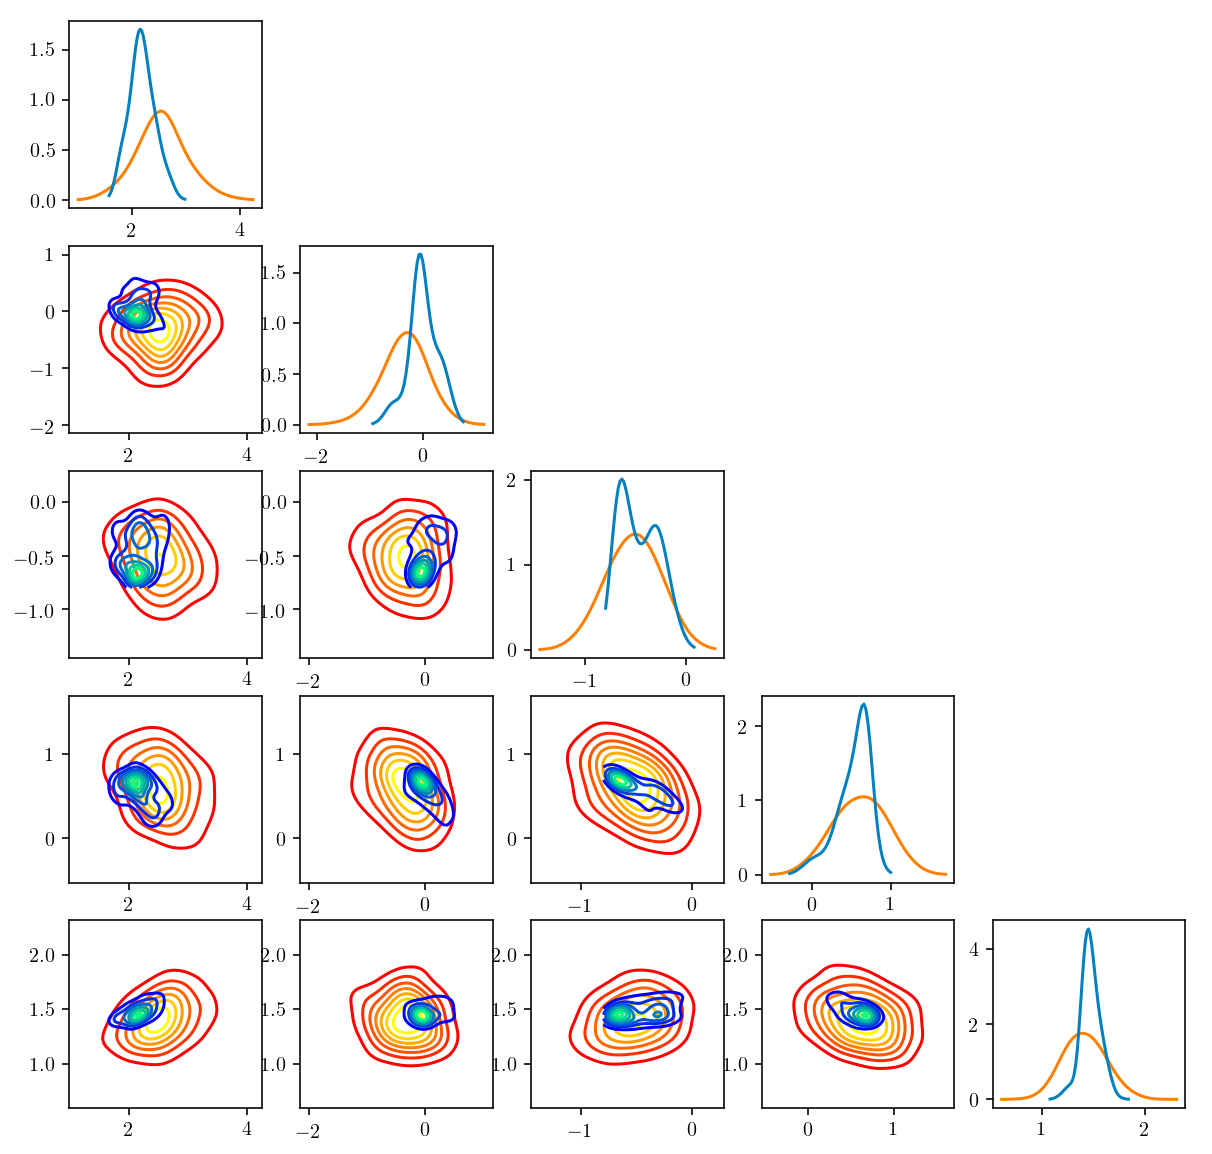

In [64]:
bw = 0.4
thin = 10
fig, axes = plt.subplots(evecs.shape[1], evecs.shape[1], False, False, figsize=(10,10))
h_pmm = component_plot(pmm_projection_fine, axes, cmap='autumn', bw=bw, thin=thin)
h_coll = component_plot(coll_projection_fine, axes, cmap='winter', bw=bw, thin=thin)
#h_coll = component_plot(truth_projection, axes, cmap='Greys', bw=bw, thin=thin)

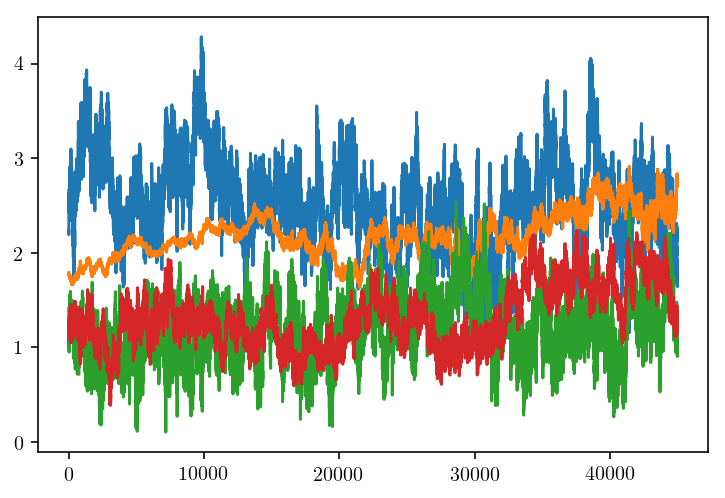

In [66]:
plt.plot(pmm_projection_fine[:,0])
plt.plot(coll_projection_fine[:,0])
plt.plot(pmm_projection_coarse[:,0])
plt.plot(coll_projection_coarse[:,0])

# Plot conductivity fields

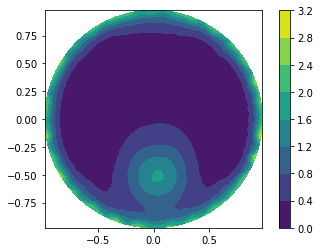

In [13]:
# load model solution
true_nodes = np.loadtxt('eit_model_sol/nodes.csv', delimiter=',')
true_elems = np.loadtxt('eit_model_sol/elems.csv', delimiter=',', dtype=np.int) - 1
true_values = np.loadtxt('eit_model_sol/elem_data.csv', delimiter=',')
approx_locations = true_nodes[true_elems].mean(axis=1)
plt.tricontourf(approx_locations[:,0], approx_locations[:,1], true_values)
plt.gca().set_aspect('equal')
plt.colorbar()

In [14]:
from scipy.spatial.distance import cdist
ls = 0.05
m1 = np.exp(-cdist(field_pts, approx_locations)**2 / (2*ls**2))
m2 = np.exp(-cdist(approx_locations, approx_locations)**2 / (2*ls**2))
log_field_values = np.dot(m1, np.linalg.solve(m2, np.log(true_values)))
field_values = np.exp(log_field_values)

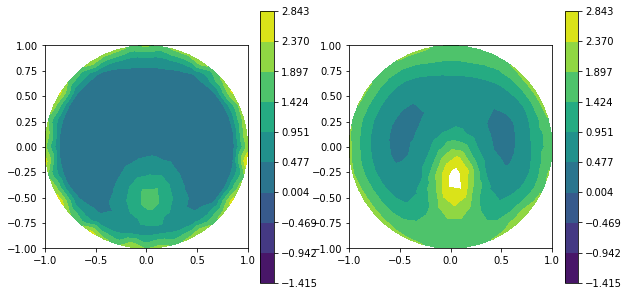

In [15]:

tmp_samples = np.load('eit_results/regular_n=209/results.npy')
level_min = np.minimum(np.min(field_values), np.min(tmp_samples))
level_max = np.maximum(np.max(field_values), np.max(tmp_samples))
levels = np.linspace(level_min, level_max, 10)
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.tricontourf(field_pts[:,0], field_pts[:,1], field_values, levels)
plt.gca().set_aspect('equal')
plt.colorbar()
plt.subplot(122)
plt.tricontourf(field_pts[:,0], field_pts[:,1], np.exp(np.mean(tmp_samples[burn:], axis=0)), levels)
plt.gca().set_aspect('equal')
plt.colorbar()

In [17]:
burn = 5000
truth = 'sim_data/truth2.txt'
true_diff = np.loadtxt(truth)
means = {}
means_coll = {}

for ix, n in enumerate(ns):
    fname = 'eit_results/regular_n={}/results.npy'.format(n)
    fname_coll = 'eit_results/regular_n={}_collocate/results.npy'.format(n)
    samples = np.load(fname)
    samples_coll = np.load(fname_coll)
    means[n] = np.mean(np.exp(samples[burn:]), axis=0)
    means_coll[n] = np.mean(np.exp(samples_coll[burn:]), axis=0)

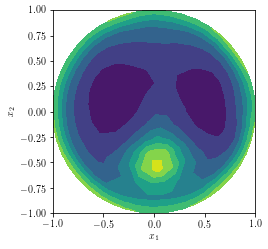

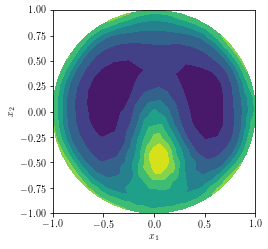

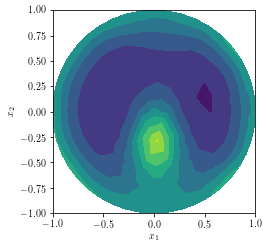

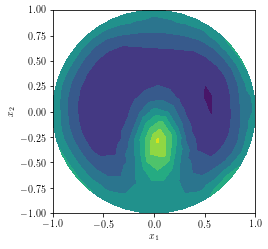

In [27]:
vmin = min([np.min(v) for v in means.values()])
vmax = max([np.max(v) for v in means.values()])
for n in ns:
    plt.figure(figsize=(8,4))
    plt.subplot(121)
    plt.tricontourf(field_pts[:,0], field_pts[:,1], means[n])#, (vmin, vmax))
    plt.gca().set_aspect('equal')
    plt.xlabel('$x_1$')
    plt.ylabel('$x_2$')
    plt.savefig('figures/eit_recovered_n={}.pdf'.format(n), bbox_inches='tight', transparent=True)
    
    
    #plt.subplot(122)
    #plt.tricontourf(field_pts[:,0], field_pts[:,1], means_coll[n])#, (vmin, vmax))
    #plt.gca().set_aspect('equal')
    #plt.savefig('figures/eit_conductivity_n={}.pdf'.format(n), transparent=True, bbox_inches=0)

In [20]:
ref_samples = np.exp(np.load('eit_results/regular_n=259/results.npy')[burn:, :])
ref_mean = np.mean(ref_samples, axis=0)

errs = []
for n in ns:
    mean_err = np.linalg.norm(means[n] - ref_mean)
    print n, mean_err
    errs.append(mean_err)

96 4.68638991328
127 2.86153012344
165 1.28189055257
209 0.860851029048


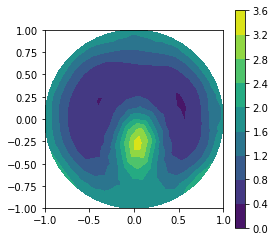

In [21]:
plt.figure(figsize=(4,4))
plt.tricontourf(field_pts[:,0], field_pts[:,1], ref_mean)#, (vmin, vmax))
plt.gca().set_aspect('equal')
plt.colorbar()

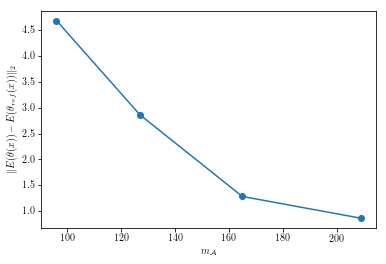

In [30]:
plt.plot(ns, errs, marker='o')
plt.xlabel('$m_\mathcal{A}$')
plt.ylabel('$\\| \\mathbb{E}(\\theta(x)) - \\mathbb{E}(\\theta_{\\text{ref}}(x)) \\|_2$ ')
plt.savefig('figures/eit_mean_convergence.pdf', bbox_inches='tight', transparent=True)